

> Bloc en retrait


# Super-resolution with CNN

 
## Objective:

We want to implement a Convolutional Neural Network (CNN) to do image super-resolution.

## Image super-resolution:

The super-resolution problem can be summarised as follows. We have an image as an input, which is defined over a grid $\{0,1,\dots, m-1\} \times \{0,1,\dots, n-1\}$. We define a factor $\delta$, by which we upsample the image. The output of the super-resolution is an image defined on the grid $\{0,\frac{1}{\delta},\dots, m-1\} \times \{0,\frac{1}{\delta},\dots, n-1\}$.


## Dataset

We will be using the mnist dataset for this part. This is to ensure we can obtain good results. The input data should be the subsampled version of the mnist images, subsampled by taking one out of every $\delta$ pixels. The output data should be the normal-resolution mnist images.

__IMPORTANT NOTES:__
- We will use ```n_max=5000``` to limit the number of datapoints to go faster
- We set $\delta$ to 2


We have created a function ```super_res_interpolate```, which carries out super-resolution using basic interpolation (bilinear or bicubic), with which we can compare your results visually and numerically.



In [ ]:

# # Load packages

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras import optimizers
from scipy import interpolate
print(tf.keras.__version__)

2.7.0


 This function carries out a bilinear upsampling, with which we can compare our super-resolution.

In [ ]:
# choice of the interpolation method
interp_method = 'linear'
# upsampling factor
delta = 2
# the maximum number of data to take from mnist (to go a bit faster)
n_max = 5000

# upsample by a factor of delta
# by definition, the new grid has a step size of 1/delta
def super_res_interpolate(imgs_in,delta,interp_method = 'linear'):
	imgs_out = tf.image.resize( tf.constant(imgs_in),\
		[delta*imgs_in.shape[1],delta*imgs_in.shape[2]], method='bilinear').numpy()

	return(imgs_out)



# Initialisation of the dataset

For the dataset, we are using MNIST Images.
Our "X" are made of images whose sizes have been divided by 2.
And the "Y" are made of the initial images.
In the following code, we are processing the data in order to have the correct shape for the next part.


In [ ]:

from keras.datasets import mnist
(X_train, Y_train_scalar), (X_test, Y_test_scalar) = mnist.load_data()

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

X_train = X_train[0:n_max,:,:]
X_test = X_test[0:n_max,:,:]

Y_train = X_train[...,tf.newaxis]
Y_test = X_test[...,tf.newaxis]

print(X_train.shape)
print(X_test.shape)


(5000, 28, 28)
(5000, 28, 28)


In [ ]:
# X_train = tf.image.resize()
X_train = X_train[...,tf.newaxis]
X_train = tf.strided_slice(X_train,[0,0,0,0],[X_train.shape[0],28,28,1],[1,2,2,1])
X_test = X_test[...,tf.newaxis]
X_test = tf.strided_slice(X_test,[0,0,0,0],[X_test.shape[0],28,28,1],[1,2,2,1])

print(X_train.shape)
print(X_test.shape)

(5000, 14, 14, 1)
(5000, 14, 14, 1)


# The model

We are relying on a paper presented in class for the construction of the model.

http://mmlab.ie.cuhk.edu.hk/projects/SRCNN.html

Chao Dong, Chen Change Loy, Kaiming He, Xiaoou Tang. Learning a Deep Convolutional Network for Image Super-Resolution, in Proceedings of European Conference on Computer Vision (ECCV), 2014 

So basically we are first resizing our images through an Upsampling layer.
Then we are setting 3 CNN (2 Conv2D and 1 Conv2DTranspose).
We are using ReLU as activation functions and SAME padding. In the last layer, we put a sigmoid in order to get a pixel between 0 and 1.



In [ ]:
model = Sequential()

model.add(UpSampling2D(size=(delta,delta),data_format="channels_last",interpolation='bilinear'))
model.add(Conv2D(64,(9,9),activation='relu',padding='same'))
model.add(Conv2D(32,(1,1),activation='relu',padding='same'))
model.add(tf.keras.layers.Conv2DTranspose(1,(5,5),padding='same',activation='sigmoid'))

model.build(input_shape=(5000,14,14,1))

In [ ]:
# HYPERPARAMETERS

learning_rate = 0.01
n_epochs = 100
batch_size = 64


Next we are compiling the model. 
We are using MeanSquaredError as the loss function. This is the one that makes the more sense in regard to the objective. 
As a matter of fact, we want to minimize the value of the pixels between the image computed and the real image.


In [ ]:
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])

model.summary()
model.fit(X_train, Y_train, epochs=n_epochs,batch_size=batch_size)

score = model.evaluate(X_test, Y_test, verbose=False)
print("Test set  : ", score)
print(" Loss : ", score[0])
print(" Accuracy : ", score[1])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d (UpSampling2D  (5000, 28, 28, 1)        0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (5000, 28, 28, 64)        5248      
                                                                 
 conv2d_1 (Conv2D)           (5000, 28, 28, 32)        2080      
                                                                 
 conv2d_transpose (Conv2DTra  (5000, 28, 28, 1)        801       
 nspose)                                                         
                                                                 
Total params: 8,129
Trainable params: 8,129
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
79/79 [==============================] - 3

# Conclusion

After training the model, we can see that we are getting an accuracy of 81%. The accuracy doesn't increase a lot but that's not disturbing. In fact, the accuracy is not the best way to see if 2 images looks the same. A pixel can take 256 different values. But the difference between 2 close value is not observable for human. 
That's why looking at the loss gives us more information. We can see that the loss has been divided by more than 5 so that's encouraging.

Now we are going to compare the results of our model with the result of the function from the beginning.
To do so, we'll look at the image, but we are also going to rely on a new metric, called Peak Signal Noise Ration (PSNR). It is introduced in the paper already cited above, and it is basically a good metric to measure the quality of an image and its compression. Usually, a bigger PSNR means an image of higher quality

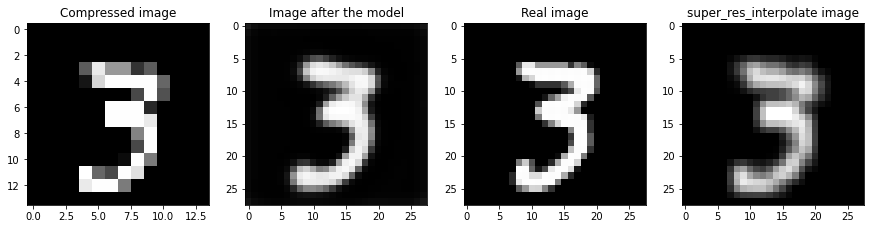

In [ ]:
fig,axs = plt.subplots(1,4,figsize=(15,15))

i = int(np.random.random() * 4997)

axs[0].imshow(X_test[i,...,0],cmap='gray')
axs[0].set_title("Compressed image")

axs[1].imshow(model(X_test)[i,...,0],cmap='gray')
axs[1].set_title("Image after the model")

axs[2].imshow(Y_test[i,...,0],cmap='gray')
axs[2].set_title("Real image")

axs[3].imshow(super_res_interpolate(X_test,2)[i,...,0],cmap='gray')
axs[3].set_title("super_res_interpolate image")

plt.show()


We can see that the model produces an image that looks a lot like the original one.

In [ ]:
def my_metric(X,Y):
  """
  We are defining the PSNR metrice between 2 images.
  
  """
  return tf.reduce_mean(tf.image.psnr(X,Y , 1))

First, we compare the PSNR computed on our images predicted and through the super_res_interpolate function

In [ ]:
Y_inter_polate_pred = super_res_interpolate(X_test,2)
Y_inter_polate_pred.shape

(5000, 28, 28, 1)

In [ ]:
my_metric(model(X_test),Y_test)

<tf.Tensor: shape=(), dtype=float32, numpy=19.97584>

In [ ]:
my_metric(Y_inter_polate_pred,Y_test)

<tf.Tensor: shape=(), dtype=float32, numpy=16.60349>

So with our model, the PSNR on the whole dataset is 20.0dB whereas it is 16.6dB through the function. 

Then, we compute the Mean Squared Loss Error

In [ ]:
tf.math.reduce_mean(((Y_inter_polate_pred) - Y_test)**2)

<tf.Tensor: shape=(), dtype=float32, numpy=0.022703482>

In [ ]:
tf.math.reduce_mean((model(X_test) - Y_test)**2)

<tf.Tensor: shape=(), dtype=float32, numpy=0.010904411>

Once again, our model is having better results (0.011 < 0.023)

Finally, we can look at the accuracy : 

In [ ]:
print("Accuracy : ", (Y_inter_polate_pred == Y_test).sum()/(5000*28*28))

Accuracy :  0.6955734693877551


The accuracy is also lower. We found 82% earlier with our model, whereas we only got 70% here.